In [22]:

filename = "20200228_mouse_liver_13C_nontumor6 Analyte 3SRD19.txt" #path to datafile
nrows = 60 #desired number of rows in output image
ncols = 120 #desired number of columns in output image
mzsOI = [235.2269] #list of m/z's to make images for
 
polarity = -1 #ionization polarity (1 = pos, -1 = neg)
ppmThresh = 20 #m/z tolerance, all peaks within ppmThresh ppm will be summed into one feature
convSquare = 3 #size of moving average filter (1=1x1,3=3x3,5=5x5)
colormap = "gray" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
threshold = True #threshold image (True) or not (False)


In [23]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import scipy.stats as stats
import skimage.filters
from helper import *
import molmass
from PIL import Image

In [24]:



#load in data and organize
data = [r.strip().split() for r in open(filename,"r").readlines()[3:]]
data = {(x[0],float(x[1]),float(x[2])):{mz:float(i) for mz,i in zip(data[0],x[3:])} for x in data[1:] if len(x) > 0}
data = pd.DataFrame.from_dict(data,orient="index")
cols = data.columns.values
mzs = cols


#get mzs of interest
mzMatchDict = {i:{"true":m,"observed":[],"matched":False} for m,i in zip(mzsOI,range(len(mzsOI)))}

#find matching peaks in data and output found and missing peaks
for m,i in zip(mzsOI,range(len(mzsOI))):
    matched = False
    for m2 in mzs:
        tmpM2 = float(m2)
        if abs(m-tmpM2) / m * 1e6 < ppmThresh:
            mzMatchDict[i]["observed"].append(m2)
            mzMatchDict[i]["matched"] = True
            matched = True
            break
    if not matched:
        print("missed",m)
    else:
        print("found",m,mzMatchDict[i]["observed"])


found 235.2269 ['235.2269']


In [25]:
#gather images for mzs of interest 
tensor = []
for mz in range(len(mzsOI)):
    #iterate through mzs of interest
    if mzMatchDict[mz]["matched"]:   
        outarray = np.sum(np.array([getImage(data,x,nrows,ncols) for x in mzMatchDict[mz]["observed"]]),axis=0)
        nrows = len(outarray)
        ncols = len(outarray[0])
    else:
        outarray = np.zeros((nrows,ncols))
    tensor.append(outarray)

tensor = np.array(tensor)

image can only be downsampled


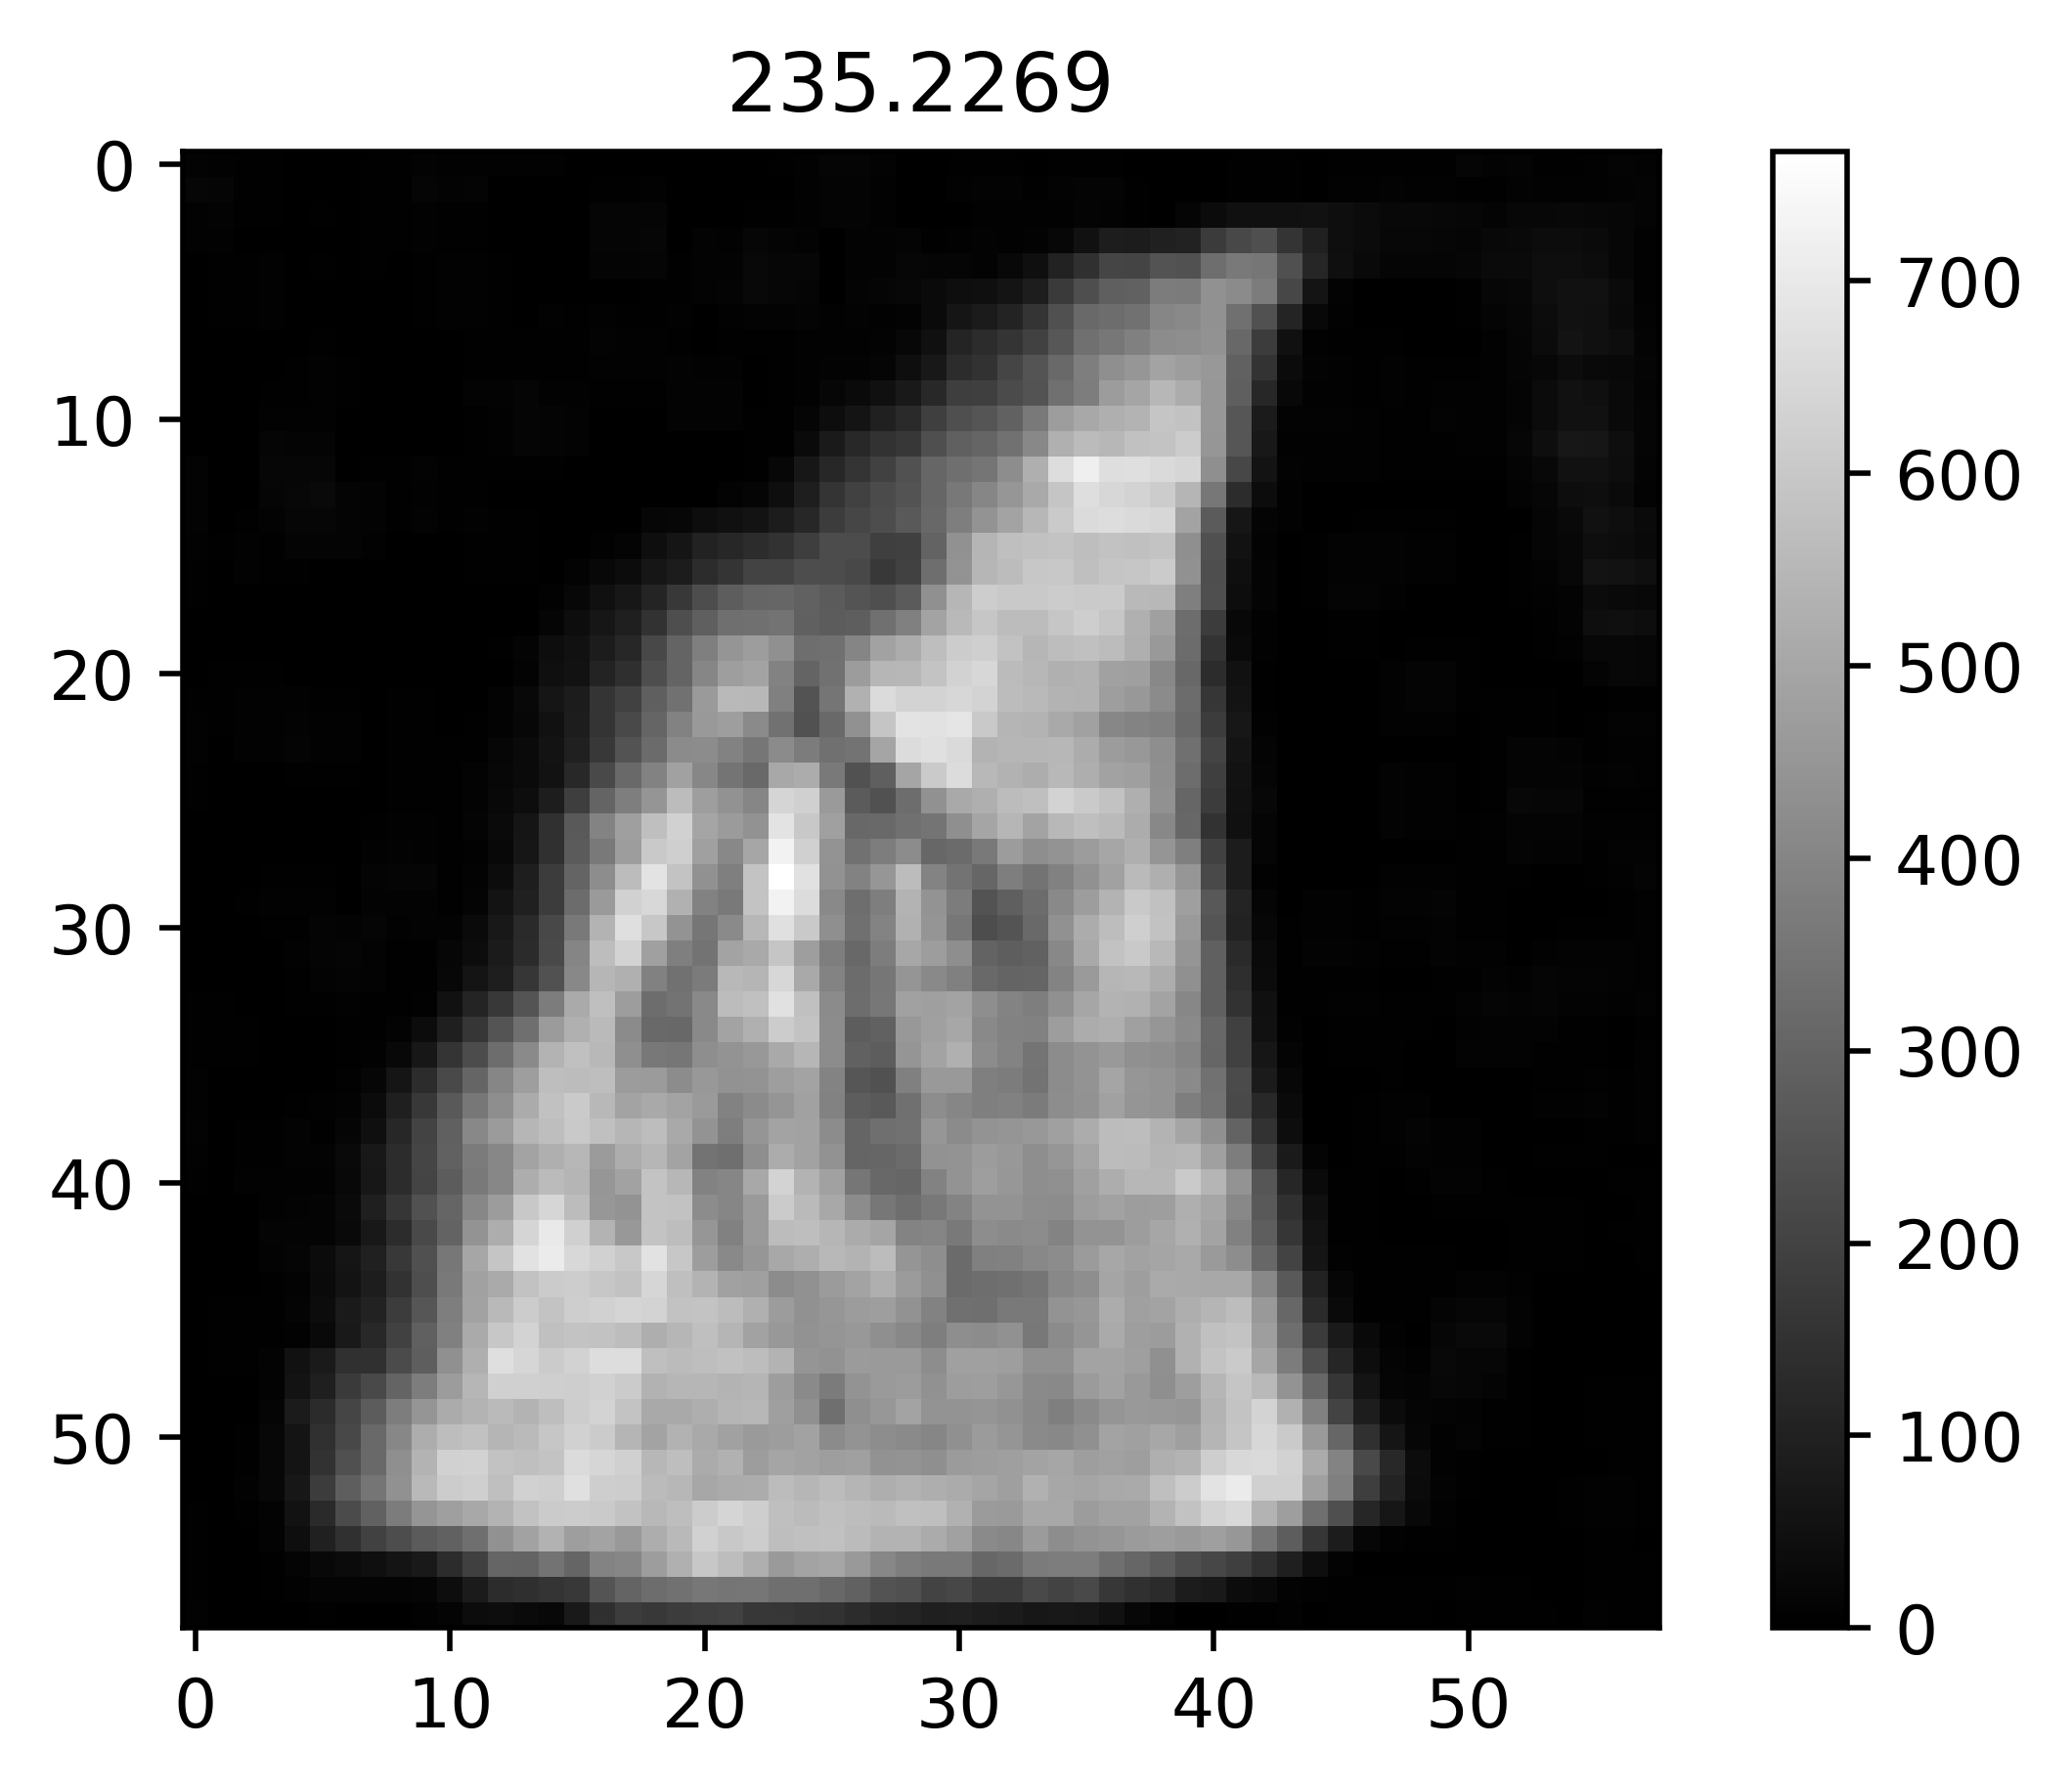

<Figure size 3000x2000 with 0 Axes>

In [26]:
#get thresholded image to define sample boundary

#create TIC image

#go through all features in dataset
if threshold:
    sumImage = np.sum([getImage(data,x,nrows,ncols) for x in mzs],axis=0)

    plt.imshow(sumImage,cmap=colormap)
    plt.colorbar()
    plt.figure()
    plt.hist(sumImage.flatten())

    threshold = skimage.filters.threshold_otsu(sumImage)

    imageBoundary = sumImage > threshold

    plt.plot([threshold,threshold],[0,1000])

    plt.figure()

    plt.imshow(imageBoundary,cmap=colormap)
else:
    imageBoundary = tensor[0] > -1

#apply moving average filter
offset = int((convSquare-1)/2)
tensorFilt = np.zeros((len(tensor),nrows-2*offset,ncols-2*offset))
newImageBoundary = np.zeros((nrows-2*offset,ncols-2*offset))
for r in range(offset,nrows-offset):
    for c in range(offset,ncols-offset):
        newImageBoundary[r-offset:r+offset+1,c-offset:c+offset+1] = imageBoundary[r,c]
        for t in range(len(tensor)):
            tempMat = tensor[t,r-offset:r+offset+1,c-offset:c+offset+1]
            coef = imageBoundary[r-offset:r+offset+1,c-offset:c+offset+1]
            coef = coef / max([1,np.sum(coef)])
            tensorFilt[t,r-offset,c-offset] = np.sum(np.multiply(tempMat,coef))
#output images
for t,mz in zip(tensorFilt,mzsOI):
    im = Image.fromarray(t)
    im.save(filename.replace(".txt","") + "_" + str(mz) + '.tif')
    plt.imshow(t,cmap=colormap)
    plt.colorbar()
    plt.title(str(mz))
    plt.figure()
    